In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from pandas import read_csv
from datetime import datetime
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [4]:
df = pd.read_csv('../api_data/hourly_building_consumption.csv')
df.head()

,Hour,Total_consumption
0,2022-11-09 00:00:00,5.6620
1,2022-11-09 01:00:00,5.6104
2,2022-11-09 02:00:00,5.4822
3,2022-11-09 03:00:00,5.4978
4,2022-11-09 04:00:00,5.7415


In [5]:
# 1. Convert Hour to DateTime type
df['Hour'] = pd.to_datetime(df['Hour'])

# 2. Set Hour as the DataFrame index
df = df.set_index('Hour')

# 3. Reindex to every hour in the range from the min to max timestamps
all_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df_reindexed = df.reindex(all_hours)

# 4. Identify which rows are missing
missing_rows = df_reindexed[df_reindexed['Total_consumption'].isnull()]
print("Missing rows:")
print(missing_rows)

Missing rows:
                     Total_consumption
2023-03-26 02:00:00                NaN
2023-09-06 01:00:00                NaN
2023-09-06 02:00:00                NaN
2023-09-06 03:00:00                NaN
2023-09-06 04:00:00                NaN
2023-09-06 05:00:00                NaN
2023-09-06 06:00:00                NaN
2023-09-06 07:00:00                NaN
2023-09-06 08:00:00                NaN
2023-09-06 09:00:00                NaN
2023-09-06 10:00:00                NaN
2023-09-06 11:00:00                NaN
2023-09-06 12:00:00                NaN
2023-09-06 13:00:00                NaN
2023-09-06 14:00:00                NaN
2023-09-06 15:00:00                NaN
2023-09-06 16:00:00                NaN
2023-09-06 17:00:00                NaN
2023-09-06 18:00:00                NaN
2023-09-06 19:00:00                NaN
2023-09-06 20:00:00                NaN
2023-09-06 21:00:00                NaN
2023-09-06 22:00:00                NaN
2023-09-06 23:00:00                NaN
2024-03-31 

C:\Users\user\AppData\Local\Temp\ipykernel_26820\2161392952.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


In [6]:
# Create a string key for month-day-hour, e.g. '09-06-03'
df_reindexed['month_day_hour'] = df_reindexed.index.strftime('%m-%d-%H')

# Compute the mean for each specific month/day/hour across all years
mdh_mean = df_reindexed.groupby('month_day_hour')['Total_consumption'].transform('mean')

# Fill missing values with that mean
df['Total_consumption'] = df_reindexed['Total_consumption'].fillna(mdh_mean)

# Clean up the extra grouping column
df_reindexed.drop(columns=['month_day_hour'], inplace=True)

df.isna().sum()
df

,Total_consumption
Hour,
2022-11-09 00:00:00,5.6620
2022-11-09 01:00:00,5.6104
2022-11-09 02:00:00,5.4822
2022-11-09 03:00:00,5.4978
2022-11-09 04:00:00,5.7415
...,...
2025-02-19 08:00:00,30.8544
2025-02-19 09:00:00,31.4423
2025-02-19 10:00:00,24.0960


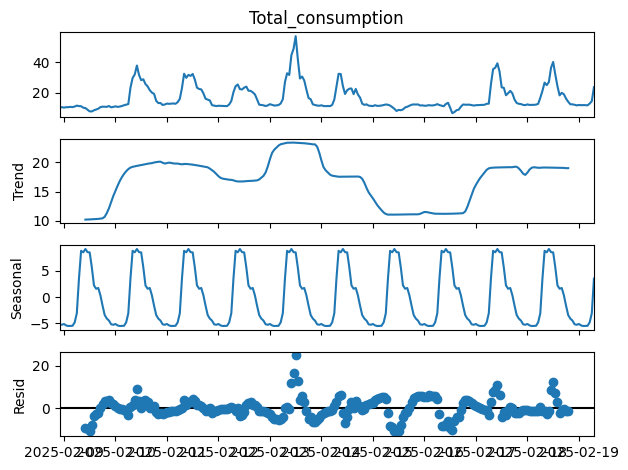

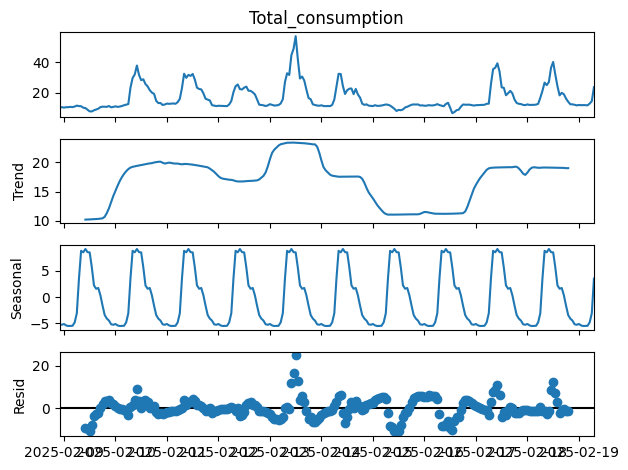

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_filtered = df.iloc[19750:20000:]

results = seasonal_decompose(df_filtered['Total_consumption'])
results.plot()

In [9]:
#dropping rows with missing df
df = df.dropna()
#checking missing data
df.isna().sum()

Total_consumption    0
dtype: int64

<Axes: xlabel='Hour'>

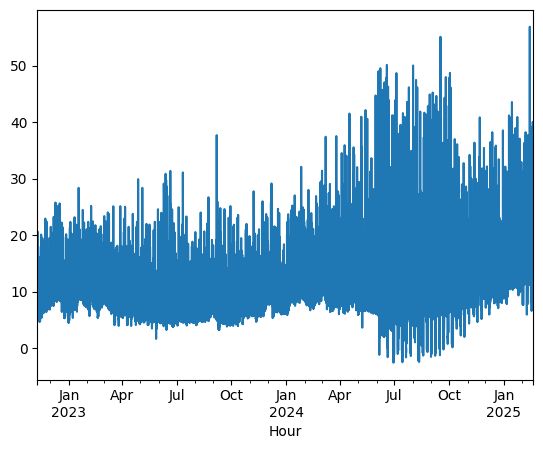

In [10]:
consumption = df['Total_consumption']
consumption.plot()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# TensorFlow imports (change to your preferred framework if needed)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Dense

# -------------------------------------------------------
# 1. Filter data to desired date range
# -------------------------------------------------------
start_date = "2022-09-11"
end_date   = "2025-02-19"
df = df.loc[start_date:end_date]

# -------------------------------------------------------
# 2. Visualize data before normalization (optional)
# -------------------------------------------------------
df["Total_consumption"].plot(figsize=(16,4), legend=True)
plt.title('Hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

# -------------------------------------------------------
# 3. Normalize data
#    (Only "Total_consumption" in this example.)
# -------------------------------------------------------
def normalize_data(df):
    scaler = MinMaxScaler()
    df["Total_consumption"] = scaler.fit_transform(
        df["Total_consumption"].values.reshape(-1,1)
    )
    return df, scaler

df_norm, scaler = normalize_data(df.copy())

# Visualize after normalization (optional)
df_norm["Total_consumption"].plot(figsize=(16,4), legend=True)
plt.title("Hourly power consumption df - AFTER NORMALIZATION")
plt.show()

# -------------------------------------------------------
# 4. Create sequences from your normalized column
# -------------------------------------------------------
def create_sequences(data_arr, seq_len):
    """
    data_arr: a 1D numpy array (already normalized)
    seq_len : number of time steps per sample
    Returns: X, y
    """
    X, y = [], []
    for i in range(seq_len, len(data_arr)):
        # The previous seq_len values as input
        X.append(data_arr[i - seq_len : i])
        # The current value as the label
        y.append(data_arr[i])
    X = np.array(X)
    y = np.array(y)
    return X, y

seq_len = 20
consumption_arr = df_norm["Total_consumption"].values
X, y = create_sequences(consumption_arr, seq_len)

# -------------------------------------------------------
# 5. Split into train, validation, and test sets
# -------------------------------------------------------
# Example ratio: 70% train, 15% validation, 15% test.
train_size = int(len(X) * 0.80)
val_size   = int(len(X) * 0.10)
test_size  = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y[train_size + val_size :]

# Reshape for RNN/LSTM [samples, timesteps, features=1]
X_train = X_train.reshape(X_train.shape[0], seq_len, 1)
X_val   = X_val.reshape(X_val.shape[0], seq_len, 1)
X_test  = X_test.reshape(X_test.shape[0], seq_len, 1)

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_val.shape   =", X_val.shape)
print("y_val.shape   =", y_val.shape)
print("X_test.shape  =", X_test.shape)
print("y_test.shape  =", y_test.shape)

# -------------------------------------------------------
# 6. Build a simple RNN model
# -------------------------------------------------------
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=True,
                        input_shape=(seq_len, 1)))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=True))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=False))
rnn_model.add(Dropout(0.15))
rnn_model.add(Dense(1))

rnn_model.summary()

# -------------------------------------------------------
# 7. Train and evaluate RNN model (with validation data)
# -------------------------------------------------------
rnn_model.compile(optimizer="adam", loss="MSE")

rnn_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val)  # Provide validation data
)

# RNN predictions on the test set
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test, rnn_predictions)
print("R2 Score of RNN model: ", rnn_score)

# Forecast errors and bias
forecast_errors = y_test.reshape(-1) - rnn_predictions.reshape(-1)
bias = np.mean(forecast_errors)
print('Bias: %f' % bias)

# Mean Absolute Error
mae = mean_absolute_error(y_test, rnn_predictions)
print('MAE: %f' % mae)

# Root Mean Squared Error
mse = mean_squared_error(y_test, rnn_predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

# Plot function
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, label='Actual power consumption')
    plt.plot(predicted, alpha=0.7, label='Predicted power consumption')
    plt.title(title)
    plt.xlabel('Time (test points)')
    plt.ylabel('Normalized consumption')
    plt.legend()
    plt.show()

plot_predictions(y_test, rnn_predictions, "RNN Predictions vs Actual")

# -------------------------------------------------------
# 8. Build an LSTM model (with validation data)
# -------------------------------------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(40, activation="tanh", return_sequences=True,
                    input_shape=(seq_len, 1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation="tanh", return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation="tanh", return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))

lstm_model.summary()

lstm_model.compile(optimizer="adam", loss="MSE")

lstm_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val)  # Provide validation data
)

# LSTM predictions on the test set
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model:", lstm_score)

# Forecast errors and bias
forecast_errors_lstm = y_test.reshape(-1) - lstm_predictions.reshape(-1)
bias_lstm = np.mean(forecast_errors_lstm)
print('Bias (LSTM): %f' % bias_lstm)

# Mean Absolute Error
mae_lstm = mean_absolute_error(y_test, lstm_predictions)
print('MAE (LSTM): %f' % mae_lstm)

# Root Mean Squared Error
mse_lstm = mean_squared_error(y_test, lstm_predictions)
rmse_lstm = sqrt(mse_lstm)
print('RMSE (LSTM): %f' % rmse_lstm)

plot_predictions(y_test, lstm_predictions, "LSTM Predictions vs Actual")

# -------------------------------------------------------
# 9. Compare RNN vs LSTM predictions in one graph
# -------------------------------------------------------
plt.figure(figsize=(16,4))
plt.plot(y_test, label="Actual values", linewidth=3)
plt.plot(rnn_predictions, label="RNN predictions", linewidth=3, alpha=0.7)
plt.plot(lstm_predictions, label="LSTM predictions", linewidth=3, alpha=0.7)
plt.legend()
plt.title("Predictions vs Actual Data")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Dense

# -------------------------------------------------------
# 1. Filter data to desired date range
# -------------------------------------------------------
start_date = "2022-09-11"
end_date   = "2025-02-19"
df = df.loc[start_date:end_date]

# -------------------------------------------------------
# 2. (Optional) Visualize data before normalization
# -------------------------------------------------------
df["Total_consumption"].plot(figsize=(16,4), legend=True)
plt.title('Hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

# -------------------------------------------------------
# 3. Normalize data
# -------------------------------------------------------
def normalize_data(df):
    scaler = MinMaxScaler()
    df["Total_consumption"] = scaler.fit_transform(
        df["Total_consumption"].values.reshape(-1,1)
    )
    return df, scaler

df_norm, scaler = normalize_data(df.copy())

# (Optional) Visualize after normalization
df_norm["Total_consumption"].plot(figsize=(16,4), legend=True)
plt.title("Hourly power consumption data - AFTER NORMALIZATION")
plt.show()

# -------------------------------------------------------
# 4. Create sequences for multi-step forecasting
#    We want each sample to predict the next 24 hours.
# -------------------------------------------------------
def create_sequences(data_arr, seq_len, forecast_horizon):
    """
    data_arr: 1D NumPy array (already normalized).
    seq_len: Number of historical time steps per sample.
    forecast_horizon: How many hours ahead we want to forecast.
    
    Returns:
      X: shape (num_samples, seq_len)
      y: shape (num_samples, forecast_horizon)
    """
    X, y = [], []
    for i in range(seq_len, len(data_arr) - forecast_horizon + 1):
        # The previous seq_len values as input
        X.append(data_arr[i - seq_len : i])
        # The next 'forecast_horizon' values as the label
        y.append(data_arr[i : i + forecast_horizon])
    return np.array(X), np.array(y)

seq_len = 20
forecast_horizon = 24

consumption_arr = df_norm["Total_consumption"].values

# Create multi-step sequences
X, y = create_sequences(consumption_arr, seq_len, forecast_horizon)

# -------------------------------------------------------
# 5. Split into train, validation, and test sets
# -------------------------------------------------------
train_size = int(len(X) * 0.80)
val_size   = int(len(X) * 0.10)
test_size  = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y[train_size + val_size :]

# Reshape for RNN/LSTM: [samples, timesteps, features=1]
X_train = X_train.reshape(X_train.shape[0], seq_len, 1)
X_val   = X_val.reshape(X_val.shape[0], seq_len, 1)
X_test  = X_test.reshape(X_test.shape[0], seq_len, 1)

print("X_train.shape =", X_train.shape)  # (num_train_samples, 20, 1)
print("y_train.shape =", y_train.shape)  # (num_train_samples, 24)
print("X_val.shape   =", X_val.shape)
print("y_val.shape   =", y_val.shape)
print("X_test.shape  =", X_test.shape)
print("y_test.shape  =", y_test.shape)

# -------------------------------------------------------
# 6. Build an RNN model for 24-hour forecasting
# -------------------------------------------------------
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=True,
                        input_shape=(seq_len, 1)))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=True))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=False))
rnn_model.add(Dropout(0.15))

# Output Dense now has 'forecast_horizon' neurons (24)
rnn_model.add(Dense(forecast_horizon))

rnn_model.summary()

rnn_model.compile(optimizer="adam", loss="MSE")

# -------------------------------------------------------
# 7. Train RNN model
# -------------------------------------------------------
rnn_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val)
)

# -------------------------------------------------------
# 8. Evaluate the RNN on the test set
# -------------------------------------------------------
rnn_predictions = rnn_model.predict(X_test)
# rnn_predictions.shape => (num_test_samples, 24)

# Flatten actual & predictions so we can compute overall metrics
rnn_predictions_flat = rnn_predictions.flatten()
y_test_flat = y_test.flatten()

rnn_score = r2_score(y_test_flat, rnn_predictions_flat)
mae = mean_absolute_error(y_test_flat, rnn_predictions_flat)
mse = mean_squared_error(y_test_flat, rnn_predictions_flat)
rmse = sqrt(mse)
bias = np.mean(y_test_flat - rnn_predictions_flat)

print("R^2 Score (RNN): ", rnn_score)
print('MAE (RNN): ', mae)
print('RMSE (RNN): ', rmse)
print('Bias (RNN): ', bias)

# (Optional) Plot a single example of 24-hour predictions
def plot_24h_forecast(sample_idx):
    """
    Plots the actual vs predicted for one sample in the test set.
    sample_idx is an index into X_test / y_test.
    """
    plt.figure(figsize=(12, 4))
    # Actual 24-hour values
    plt.plot(y_test[sample_idx], label='Actual Next 24h')
    # Predicted 24-hour values
    plt.plot(rnn_predictions[sample_idx], label='Predicted Next 24h')
    plt.title(f'RNN 24-hour Forecast - Sample index {sample_idx}')
    plt.xlabel('Hour Ahead')
    plt.ylabel('Normalized consumption')
    plt.legend()
    plt.show()

# Example: plot predictions for the first (or last) test sample
plot_24h_forecast(sample_idx=0)

# -------------------------------------------------------
# 9. Build and train an LSTM model for 24-hour forecasting
# -------------------------------------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(40, activation="tanh", return_sequences=True,
                    input_shape=(seq_len, 1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation="tanh", return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation="tanh", return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(forecast_horizon))

lstm_model.summary()
lstm_model.compile(optimizer="adam", loss="MSE")

lstm_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val)
)

# -------------------------------------------------------
# 10. Evaluate the LSTM model on the test set
# -------------------------------------------------------
lstm_predictions = lstm_model.predict(X_test)
# Flatten for overall metrics
lstm_predictions_flat = lstm_predictions.flatten()
y_test_flat = y_test.flatten()

lstm_score = r2_score(y_test_flat, lstm_predictions_flat)
mae_lstm = mean_absolute_error(y_test_flat, lstm_predictions_flat)
mse_lstm = mean_squared_error(y_test_flat, lstm_predictions_flat)
rmse_lstm = sqrt(mse_lstm)
bias_lstm = np.mean(y_test_flat - lstm_predictions_flat)

print("R^2 Score (LSTM):", lstm_score)
print('MAE (LSTM):', mae_lstm)
print('RMSE (LSTM):', rmse_lstm)
print('Bias (LSTM):', bias_lstm)

# Plot one example of 24-hour LSTM forecasts
def plot_24h_forecast_lstm(sample_idx):
    plt.figure(figsize=(12, 4))
    plt.plot(y_test[sample_idx], label='Actual Next 24h')
    plt.plot(lstm_predictions[sample_idx], label='Predicted Next 24h')
    plt.title(f'LSTM 24-hour Forecast - Sample index {sample_idx}')
    plt.xlabel('Hour Ahead')
    plt.ylabel('Normalized consumption')
    plt.legend()
    plt.show()

plot_24h_forecast_lstm(sample_idx=0)

# -------------------------------------------------------
# 11. Compare RNN vs LSTM for a single test sample
# -------------------------------------------------------
sample_idx = 0
plt.figure(figsize=(12,4))
plt.plot(y_test[sample_idx], label="Actual 24h", linewidth=3)
plt.plot(rnn_predictions[sample_idx], label="RNN", linewidth=3, alpha=0.7)
plt.plot(lstm_predictions[sample_idx], label="LSTM", linewidth=3, alpha=0.7)
plt.legend()
plt.title(f"24-hour Forecast Comparison - Sample {sample_idx}")
plt.xlabel('Hour Ahead')
plt.ylabel('Normalized consumption')
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_20004\3584935728.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\user\AppData\Local\Temp\ipykernel_20004\3584935728.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.dayofweek
C:\Users\user\AppData\Local\Temp\ipykernel_20004\3584935728.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

DataFrame after feature engineering:
                     Total_consumption  hour  day_of_week  month  is_weekend  \
Hour                                                                           
2022-11-09 00:00:00             5.6620     0            2     11           0   
2022-11-09 01:00:00             5.6104     1            2     11           0   
2022-11-09 02:00:00             5.4822     2            2     11           0   
2022-11-09 03:00:00             5.4978     3            2     11           0   
2022-11-09 04:00:00             5.7415     4            2     11           0   

                     is_festive  working_hour  is_summer  is_winter  \
Hour                                                                  
2022-11-09 00:00:00           0             0          0          0   
2022-11-09 01:00:00           0             0          0          0   
2022-11-09 02:00:00           0             0          0          0   
2022-11-09 03:00:00           0             0  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,761 (34.22 KB)

 Trainable params: 8,761 (34.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3511
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1405
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0790
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0531
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0410
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0332
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0262
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0224
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0187
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0157
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0134
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0119
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0107
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0094
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0086
Epoc

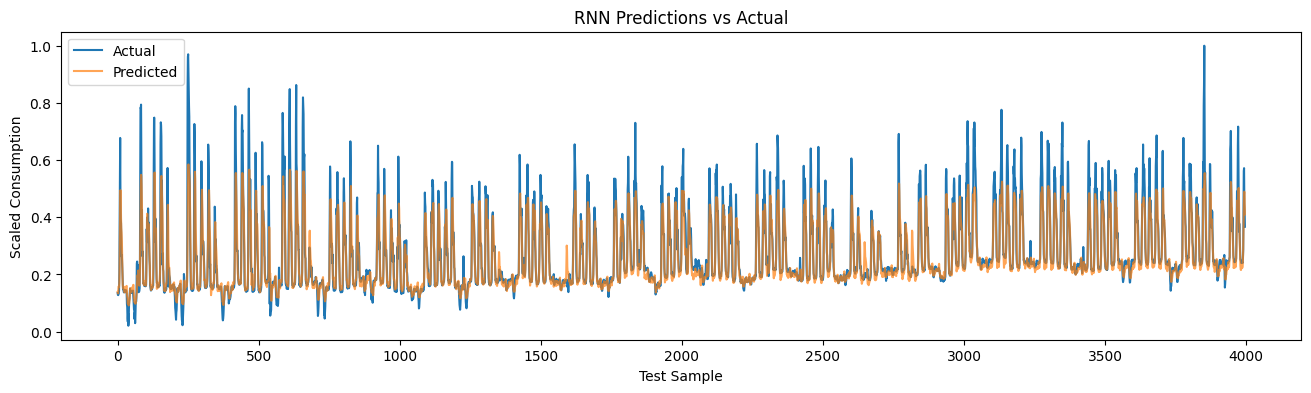

c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 40)         │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 40)         │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,921 (136.41 KB)

 Trainable params: 34,921 (136.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0154
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0056
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0045
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0044
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0039
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0039
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0035
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0033
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0030
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0030
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0029
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0028
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0028
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0027
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0024
Epoc

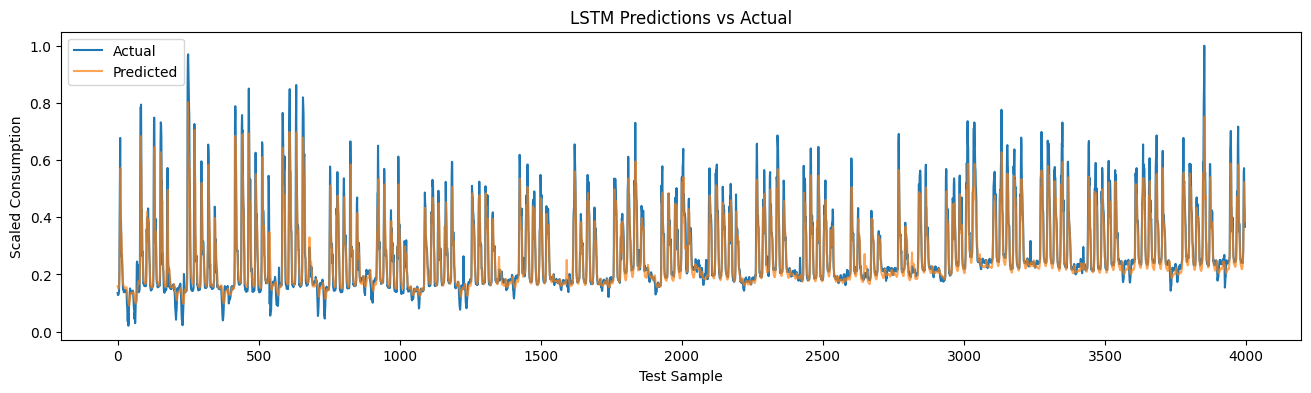

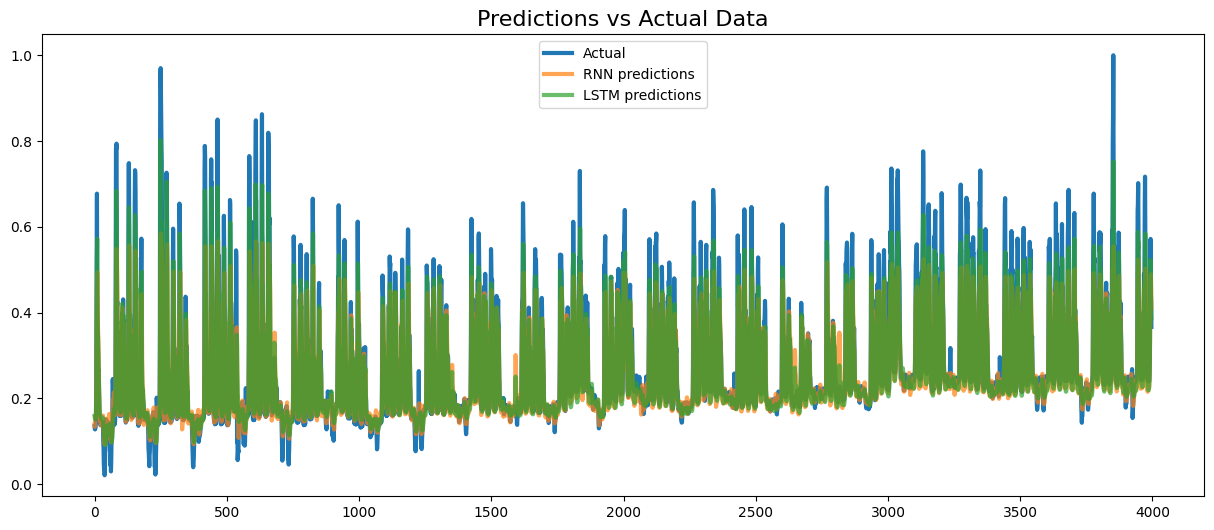

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# TensorFlow imports (change to your preferred framework if needed)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Dense

# Filter data to your chosen date range
start_date = "2022-09-11"
end_date   = "2025-02-19"
df = df.loc[start_date:end_date]

# ------------------------------------------------------------------------
# 2. Additional features (including cyclical and categorical embeddings)
# ------------------------------------------------------------------------
# Example holiday set (Belgian holidays, or any other). 
# Replace with actual holiday dates as a set of datetime.date objects:
be_holidays = {
    # For illustration, pretend we have a few random holiday dates
    # e.g., datetime(2022, 12, 25).date()
    # or use whatever holiday set your project requires
}

# Hour, day-of-week, month
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Categorical features
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['is_festive'] = df.index.to_series().apply(lambda x: 1 if x.date() in be_holidays else 0)
df['working_hour'] = df['hour'].apply(lambda x: 1 if 8 <= x <= 18 else 0)

# Seasonal features
df['is_summer'] = df.index.month.isin([6, 7, 8]).astype(int)
df['is_winter'] = df.index.month.isin([12, 1, 2]).astype(int)

# Peak hour features
df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
df['is_evening_peak'] = ((df['hour'] >= 17) & (df['hour'] <= 20)).astype(int)

# Cyclical features for hour and day of week
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# ------------------------------------------------------------------------
# 3. Inspect the DataFrame
# ------------------------------------------------------------------------
print("DataFrame after feature engineering:")
print(df.head())

# ------------------------------------------------------------------------
# 4. Normalize the data
#    We'll use one MinMaxScaler for all columns used as inputs (including
#    'Total_consumption') so everything is on [0,1].
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

# ------------------------------------------------------------------------
# 5. Create sequences for a multi-feature time series
# ------------------------------------------------------------------------
def create_sequences_multifeature(df, seq_len, target_col):
    """
    df: DataFrame of scaled features (all numeric).
    seq_len: number of time steps per sequence.
    target_col: name of the target column to predict (e.g. 'Total_consumption').
    
    Returns:
    X - shape: (num_samples, seq_len, num_features)
    y - shape: (num_samples,)
    """
    X, y = [], []
    data_values = df.values  # shape: (num_samples, num_features)
    target_idx = df.columns.get_loc(target_col)
    
    for i in range(seq_len, len(df)):
        # For each sequence, we take rows [i-seq_len, i) of all columns
        X.append(data_values[i-seq_len:i, :])
        # The label is the target column at position i
        y.append(data_values[i, target_idx])
        
    X = np.array(X)
    y = np.array(y)
    return X, y

# We'll predict "Total_consumption"
seq_len = 20
target_col = "Total_consumption"
X, y = create_sequences_multifeature(df_scaled, seq_len, target_col)

print(f"\nCreated sequences with shape X: {X.shape}, y: {y.shape}")

# ------------------------------------------------------------------------
# 6. Split into train/test sets
# ------------------------------------------------------------------------
train_size = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train.shape =", X_train.shape)  # (train_size, seq_len, n_features)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)    # (test_size, seq_len, n_features)
print("y_test.shape =", y_test.shape)

# ------------------------------------------------------------------------
# 7. Build and train a Simple RNN model
# ------------------------------------------------------------------------
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=True,
                        input_shape=(seq_len, X.shape[2])))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=True))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40, activation="tanh", return_sequences=False))
rnn_model.add(Dropout(0.15))
rnn_model.add(Dense(1))

rnn_model.summary()

rnn_model.compile(optimizer="adam", loss="mse")
rnn_model.fit(X_train, y_train, epochs=50, batch_size=256)

# ------------------------------------------------------------------------
# 8. Evaluate RNN
# ------------------------------------------------------------------------
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test, rnn_predictions)
print("R2 Score (RNN):", rnn_score)

mse_rnn = mean_squared_error(y_test, rnn_predictions)
rmse_rnn = sqrt(mse_rnn)
mae_rnn = mean_absolute_error(y_test, rnn_predictions)
print("MSE (RNN):", mse_rnn)
print("RMSE (RNN):", rmse_rnn)
print("MAE (RNN):", mae_rnn)

# Simple plotting function
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, label='Actual')
    plt.plot(predicted, alpha=0.7, label='Predicted')
    plt.title(title)
    plt.xlabel('Test Sample')
    plt.ylabel('Scaled Consumption')
    plt.legend()
    plt.show()

plot_predictions(y_test, rnn_predictions, "RNN Predictions vs Actual")

# ------------------------------------------------------------------------
# 9. Build and train an LSTM model
# ------------------------------------------------------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(40, activation="tanh", return_sequences=True, 
                    input_shape=(seq_len, X.shape[2])))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation="tanh", return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation="tanh", return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))

lstm_model.summary()

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train, y_train, epochs=50, batch_size=256)

# ------------------------------------------------------------------------
# 10. Evaluate LSTM
# ------------------------------------------------------------------------
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R2 Score (LSTM):", lstm_score)

mse_lstm = mean_squared_error(y_test, lstm_predictions)
rmse_lstm = sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, lstm_predictions)
print("MSE (LSTM):", mse_lstm)
print("RMSE (LSTM):", rmse_lstm)
print("MAE (LSTM):", mae_lstm)

plot_predictions(y_test, lstm_predictions, "LSTM Predictions vs Actual")

# ------------------------------------------------------------------------
# 11. Compare RNN vs LSTM in a single plot
# ------------------------------------------------------------------------
plt.figure(figsize=(15,6))
plt.plot(y_test, label="Actual", linewidth=3)
plt.plot(rnn_predictions, label="RNN predictions", linewidth=3, alpha=0.7)
plt.plot(lstm_predictions, label="LSTM predictions", linewidth=3, alpha=0.7)
plt.title("Predictions vs Actual Data", fontsize=16)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import backend as K

# --- 1. Preprocess (SAME as before, not repeated here) ---
# Assume `df` is already filtered, feature-engineered, and scaled

# --- 2. Sequence Creation (again, same as before) ---
seq_len = 72
target_col = "Total_consumption"
X, y = create_sequences_multifeature(df_scaled, seq_len, target_col)

# --- 3. Split Train/Test ---
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# --- 4. Define custom loss ---
def weighted_mse(y_true, y_pred):
    weight = K.abs(y_true - K.mean(y_true))
    return K.mean(weight * K.square(y_pred - y_true))

# --- 5. First model: baseline LSTM ---
base_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X.shape[2]), activation='tanh'),
    Dropout(0.2),
    LSTM(64, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
base_model.compile(optimizer='adam', loss=weighted_mse)
base_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, verbose=1)

# --- 6. Predict and get residuals ---
base_pred_train = base_model.predict(X_train).flatten()
base_pred_test = base_model.predict(X_test).flatten()

residuals_train = y_train - base_pred_train
residuals_test = y_test - base_pred_test  # for evaluation only

# --- 7. Train second model on residuals ---
residual_model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(seq_len, X.shape[2]), activation='tanh'),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
residual_model.compile(optimizer='adam', loss='mse')
residual_model.fit(X_train, residuals_train, epochs=30, batch_size=128, validation_split=0.1, verbose=1)

# --- 8. Predict residuals and combine ---
residual_pred_test = residual_model.predict(X_test).flatten()
final_predictions = base_pred_test + residual_pred_test

# --- 9. Evaluation ---
r2 = r2_score(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, final_predictions)

print("\n🧠 Residual-Boosted Forecast Results:")
print(f"R2 Score: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# --- 10. Plot ---
plt.figure(figsize=(15,5))
plt.plot(y_test, label="Actual", linewidth=2)
plt.plot(base_pred_test, label="Base LSTM", linewidth=2, alpha=0.6)
plt.plot(final_predictions, label="Residual-Boosted", linewidth=2, alpha=0.9)
plt.title("Hybrid Model: Base + Residual Forecasting")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# -------------------- 1. Preprocessing --------------------
# Filter date range
start_date = "2022-09-11"
end_date   = "2025-02-19"
df = df.loc[start_date:end_date]

# Holidays placeholder
be_holidays = set()

# Time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_festive'] = df.index.to_series().apply(lambda x: 1 if x.date() in be_holidays else 0)
df['working_hour'] = df['hour'].apply(lambda x: 1 if 8 <= x <= 18 else 0)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)

# Cyclical encodings
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Rolling peak/min features
#df['past_12h_max'] = df['Total_consumption'].rolling(window=12).max().shift(1).bfill()
#df['past_12h_min'] = df['Total_consumption'].rolling(window=12).min().shift(1).bfill()

# -------------------- 2. Normalization --------------------
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# -------------------- 3. Create multi-step sequences --------------------
def create_multi_step_sequences(df, seq_len, target_col, forecast_horizon):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_col)
    for i in range(seq_len, len(df) - forecast_horizon):
        X.append(data[i-seq_len:i])
        y.append(data[i:i+forecast_horizon, target_idx])  # next 24 hours
    return np.array(X), np.array(y)

seq_len =168  # Past 72 hours
forecast_horizon = 24  # Predict next 24 hours
target_col = "Total_consumption"

X, y = create_multi_step_sequences(df_scaled, seq_len, target_col, forecast_horizon)

# -------------------- 4. Train/test split --------------------
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# -------------------- 5. Define LSTM model --------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X.shape[2]), activation='tanh'),
    Dropout(0.2),
    LSTM(64, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(forecast_horizon)  # Output vector of 24 predictions
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# -------------------- 6. Train model --------------------
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# -------------------- 7. Predict --------------------
predictions = model.predict(X_test)

# -------------------- 8. Evaluation --------------------
r2 = r2_score(y_test.flatten(), predictions.flatten())
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
rmse = sqrt(mse)
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print("\n📊 Multi-step Forecast Evaluation (24h ahead):")
print(f"R2 Score: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# -------------------- 9. Plot sample predictions --------------------
for i in range(3):
    plt.figure(figsize=(12,3))
    plt.plot(y_test[i], label="Actual (24h)", marker='o')
    plt.plot(predictions[i], label="Predicted (24h)", marker='x')
    plt.title(f"24h Forecast - Sample {i+1}")
    plt.xlabel("Hour Ahead")
    plt.ylabel("Scaled Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()


Shapes  →  (15909, 72, 15) (15909, 24) (1905, 72, 15) (1905, 24) (1906, 72, 15)


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 64)         │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 72, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,088 (344.09 KB)

 Trainable params: 88,088 (344.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
125/125 - 22s - 177ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 2/80
125/125 - 19s - 153ms/step - loss: 0.0072 - val_loss: 0.0127
Epoch 3/80
125/125 - 24s - 190ms/step - loss: 0.0060 - val_loss: 0.0117
Epoch 4/80
125/125 - 24s - 192ms/step - loss: 0.0054 - val_loss: 0.0128
Epoch 5/80
125/125 - 24s - 196ms/step - loss: 0.0050 - val_loss: 0.0146
Epoch 6/80
125/125 - 24s - 191ms/step - loss: 0.0047 - val_loss: 0.0111
Epoch 7/80
125/125 - 23s - 187ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 8/80
125/125 - 24s - 195ms/step - loss: 0.0043 - val_loss: 0.0110
Epoch 9/80
125/125 - 25s - 198ms/step - loss: 0.0042 - val_loss: 0.0103
Epoch 10/80
125/125 - 25s - 198ms/step - loss: 0.0039 - val_loss: 0.0092
Epoch 11/80
125/125 - 25s - 199ms/step - loss: 0.0038 - val_loss: 0.0111
Epoch 12/80
125/125 - 24s - 193ms/step - loss: 0.0037 - val_loss: 0.0102
Epoch 13/80
125/125 - 25s - 198ms/step - loss: 0.0036 - val_loss: 0.0101
Epoch 14/80
125/125 - 36s - 285ms/step - loss: 0.0035 - val_

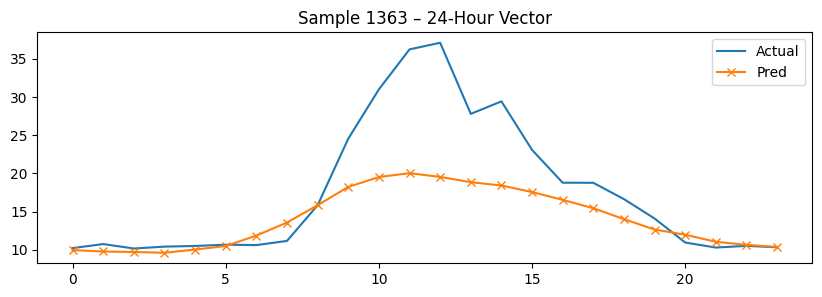

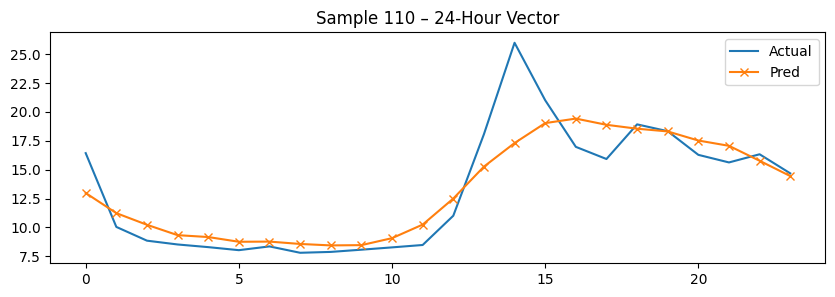

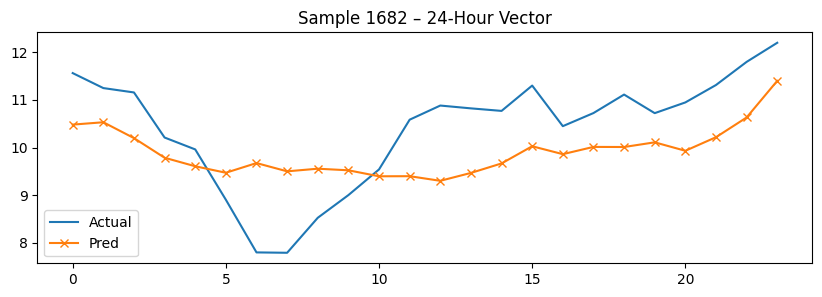

In [11]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import holidays, math

# ------------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------------
START, END          = "2022-09-11", "2025-02-19"
LOOK_BACK           = 72          # 3 days
FORECAST_HORIZON    = 24          # 24-hour vector
EPOCHS, BATCH_SIZE  = 80, 128
TARGET_COL          = "Total_consumption"

# ------------------------------------------------------------------
# 1.  Load & basic filtering (replace with your data import)
# ------------------------------------------------------------------
df = df.loc[START:END].copy()       # df already in memory

# ------------------------------------------------------------------
# 2.  Feature engineering  (calendar + cyclic + flags)
# ------------------------------------------------------------------
be_holidays = set(holidays.country_holidays(
                  "BE", years=[2022, 2023, 2024, 2025]).keys())

df["hour"]           = df.index.hour
df["day_of_week"]    = df.index.dayofweek
df["month"]          = df.index.month
df["is_weekend"]     = (df["day_of_week"] >= 5).astype(int)
df["is_festive"]     = df.index.to_series().apply(
                         lambda d: int(d.date() in be_holidays))
df["working_hour"]   = df["hour"].between(8, 18).astype(int)
df["is_summer"]      = df["month"].isin([6, 7, 8]).astype(int)
df["is_winter"]      = df["month"].isin([12, 1, 2]).astype(int)
df["is_morning_peak"] = df["hour"].between(7, 9).astype(int)
df["is_evening_peak"] = df["hour"].between(17, 20).astype(int)
df["hour_sin"]       = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"]       = np.cos(2*np.pi*df["hour"]/24)
df["dow_sin"]        = np.sin(2*np.pi*df["day_of_week"]/7)
df["dow_cos"]        = np.cos(2*np.pi*df["day_of_week"]/7)

FEATURE_COLS = [c for c in df.columns if c != TARGET_COL]

# ------------------------------------------------------------------
# 3.  Chronological train/val/test split
# ------------------------------------------------------------------
train_size = int(len(df)*0.8)
val_size   = int(len(df)*0.1)

df_train = df.iloc[:train_size]
df_val   = df.iloc[train_size:train_size+val_size]
df_test  = df.iloc[train_size+val_size:]

# ------------------------------------------------------------------
# 4.  Fit scaler on **train only** and transform all splits
# ------------------------------------------------------------------
scaler = MinMaxScaler().fit(df_train[[TARGET_COL]+FEATURE_COLS])
def scale(frame): return pd.DataFrame(
        scaler.transform(frame[[TARGET_COL]+FEATURE_COLS]),
        columns=[TARGET_COL]+FEATURE_COLS, index=frame.index)

df_train_s, df_val_s, df_test_s = map(scale, (df_train, df_val, df_test))

# ------------------------------------------------------------------
# 5.  Helper to make (X, y) sliding windows
# ------------------------------------------------------------------
def make_xy(frame, look_back, horizon, target):
    data = frame[[target]+FEATURE_COLS].values
    tgt_idx = 0
    X, y = [], []
    for i in range(look_back, len(data)-horizon+1):
        X.append(data[i-look_back:i])
        y.append(data[i:i+horizon, tgt_idx])
    return np.array(X), np.array(y)

X_train, y_train = make_xy(df_train_s, LOOK_BACK, FORECAST_HORIZON, TARGET_COL)
X_val,   y_val   = make_xy(df_val_s,   LOOK_BACK, FORECAST_HORIZON, TARGET_COL)
X_test,  y_test  = make_xy(df_test_s,  LOOK_BACK, FORECAST_HORIZON, TARGET_COL)

print("Shapes  → ",
      X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)

# ------------------------------------------------------------------
# 6.  LSTM model
# ------------------------------------------------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOK_BACK, X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(FORECAST_HORIZON)
])
model.compile(optimizer="adam", loss="mse")
model.summary()

# ------------------------------------------------------------------
# 7.  Train
# ------------------------------------------------------------------
cb = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[cb],
                    verbose=2)

# ------------------------------------------------------------------
# 8.  Predict & inverse-scale
# ------------------------------------------------------------------
pred_norm = model.predict(X_test)
def inverse(norm_vec):
    zeros = np.zeros((FORECAST_HORIZON, len(FEATURE_COLS)))
    return scaler.inverse_transform(
              np.hstack([norm_vec.reshape(-1,1), zeros]))[:,0]
y_true = np.vstack([inverse(v) for v in y_test])
y_pred = np.vstack([inverse(v) for v in pred_norm])

# ------------------------------------------------------------------
# 9.  Metrics
# ------------------------------------------------------------------
rmse = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
mae  = mean_absolute_error(y_true.flatten(), y_pred.flatten())
r2   = r2_score(y_true.flatten(), y_pred.flatten())

print(f"\n📊 24-Step Forecast – RMSE: {rmse:.2f}  MAE: {mae:.2f}  R²: {r2:.3f}")

# ------------------------------------------------------------------
# 10.  Quick visual check on 3 random test samples
# ------------------------------------------------------------------
for i in np.random.choice(len(y_true), 3, replace=False):
    plt.figure(figsize=(10,3))
    plt.plot(y_true[i], label="Actual")
    plt.plot(y_pred[i], label="Pred", marker="x")
    plt.title(f"Sample {i} – 24-Hour Vector"); plt.legend(); plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# -------------------- 1. Preprocessing --------------------
# Define date range. We now extend end_date by 1 day to include 2025-02-20 23:00, 
# so that our DataFrame has rows for Feb 20 (though consumption might be NaN).
start_date = "2022-09-11"
end_date   = "2025-02-20 23:00"
df = df.loc[start_date:end_date]

# If you do NOT have actual consumption for 2025-02-20, 
# you can fill it with NaN or 0.  For example:
# df['Total_consumption'] = df['Total_consumption'].fillna(0)

# Add time-based features
be_holidays = set()
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_festive'] = df.index.to_series().apply(lambda x: 1 if x.date() in be_holidays else 0)
df['working_hour'] = df['hour'].apply(lambda x: 1 if 8 <= x <= 18 else 0)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)

# Cyclical time encodings
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# -------------------- 2. Normalization --------------------
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), 
                         columns=df.columns, 
                         index=df.index)

# -------------------- 3. Create multi-step sequences --------------------
def create_multi_step_sequences(df, seq_len, target_col, forecast_horizon):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_col)
    for i in range(seq_len, len(df) - forecast_horizon):
        X.append(data[i-seq_len:i])
        y.append(data[i:i+forecast_horizon, target_idx])  # next 24 hours
    return np.array(X), np.array(y)

seq_len = 168           # Use past 168 hours
forecast_horizon = 24   # Predict next 24 hours
target_col = "Total_consumption"

X, y = create_multi_step_sequences(df_scaled, seq_len, target_col, forecast_horizon)

# -------------------- 4. Train/test split --------------------
# We'll do a simple split on the entire scaled dataset.
# Make sure the final day (Feb 20) is in the test set so that
# we can produce a forecast for it.
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# -------------------- 5. Define LSTM model --------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X.shape[2]), activation='tanh'),
    Dropout(0.2),
    LSTM(64, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(forecast_horizon)  # Output vector of 24 predictions
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# -------------------- 6. Train model --------------------
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# -------------------- 7. Predict on the test set (for evaluation) --------------------
predictions = model.predict(X_test)

# -------------------- 8. Evaluation --------------------
r2 = r2_score(y_test.flatten(), predictions.flatten())
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
rmse = sqrt(mse)
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print("\n📊 Multi-step Forecast Evaluation (24h ahead) on test set:")
print(f"R2 Score: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# -------------------- 9. Plot some sample predictions --------------------
for i in range(3):
    plt.figure(figsize=(12,3))
    plt.plot(y_test[i], label="Actual (24h)", marker='o')
    plt.plot(predictions[i], label="Predicted (24h)", marker='x')
    plt.title(f"24h Forecast - Sample {i+1}")
    plt.xlabel("Hour Ahead")
    plt.ylabel("Scaled Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------- 10. Produce final 24h forecast for 20/02/2025 --------------------
# We want the sequence that ends on 2025-02-19 23:00 so we can predict 
# from 2025-02-20 00:00 to 2025-02-20 23:00.

# 1) Identify the *index* of the last valid sequence that will forecast into 20/02.
#    This corresponds to the final place in df_scaled where the next 24 hours 
#    is exactly 2025-02-20's data.

# Because we built X, y in create_multi_step_sequences from the entire df_scaled,
# we can simply take the last item of X if we want the last 24-hour forecast in the dataset:
X_for_20feb = X[-1:]  # shape becomes (1, 168, num_features)

# 2) Predict scaled
pred_24h_scaled = model.predict(X_for_20feb)[0]  # shape (24,)

# 3) Inverse-scale only the target column
#    We'll construct a "dummy" array with the same number of columns as df, 
#    place our scaled predictions in the target column, and run inverse_transform.
dummy = np.zeros((forecast_horizon, df_scaled.shape[1]))
target_idx = df_scaled.columns.get_loc(target_col)
dummy[:, target_idx] = pred_24h_scaled
dummy_inversed = scaler.inverse_transform(dummy)

# Extract just the "Total_consumption" column
forecast_20feb = dummy_inversed[:, target_idx]

# 4) Build a timestamp index for the 24 forecast hours (20/02/2025 00:00 to 23:00)
#    NOTE: Because our final sequence in create_multi_step_sequences was presumably 
#          the chunk that ends right before 20/02, these predicted 24 hours 
#          align with 20/02/2025 00:00..23:00
ts_index_20feb = pd.date_range(start="2025-02-20 00:00:00", periods=24, freq='H')
forecast_df = pd.DataFrame({"Predicted_Consumption": forecast_20feb}, index=ts_index_20feb)

print("\nFinal Forecast for 20/02/2025:")
print(forecast_df)

# (Optional) Plot the final forecast
plt.figure(figsize=(12,3))
plt.plot(forecast_df.index, forecast_20feb, marker='o', label="Forecast Feb 20")
plt.title("24h Total_consumption Consumption Forecast on 20/02/2025")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'df' is not defined

Scaler fitted and saved to './models/total_consumption_scaler.joblib'
Train shapes: (13978, 24, 5) (13978,)
Val shapes:   (1975, 24, 5) (1975,)
Test shapes:  (3977, 24, 5) (3977,)
Epoch 1/100


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


437/437 - 4s - 10ms/step - loss: 0.0108 - val_loss: 0.0125
Epoch 2/100
437/437 - 3s - 6ms/step - loss: 0.0022 - val_loss: 0.0105
Epoch 3/100
437/437 - 2s - 6ms/step - loss: 0.0018 - val_loss: 0.0091
Epoch 4/100
437/437 - 3s - 6ms/step - loss: 0.0016 - val_loss: 0.0082
Epoch 5/100
437/437 - 2s - 5ms/step - loss: 0.0014 - val_loss: 0.0074
Epoch 6/100
437/437 - 2s - 5ms/step - loss: 0.0013 - val_loss: 0.0066
Epoch 7/100
437/437 - 2s - 6ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 8/100
437/437 - 2s - 5ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 9/100
437/437 - 3s - 6ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 10/100
437/437 - 2s - 5ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 11/100
437/437 - 2s - 6ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 12/100
437/437 - 2s - 6ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 13/100
437/437 - 2s - 6ms/step - loss: 0.0011 - val_loss: 0.0052
Epoch 14/100
437/437 - 2s - 5ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 15/100
437/437 - 2s 

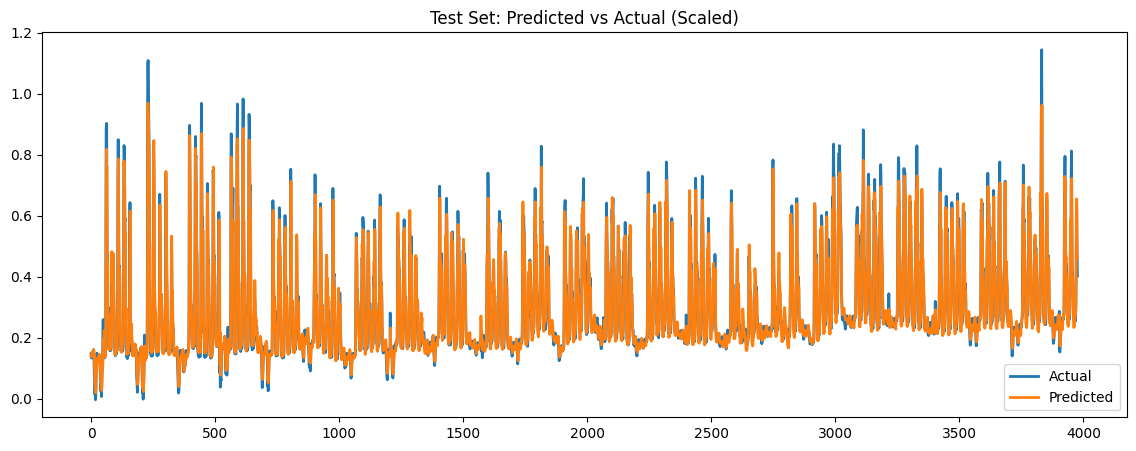

<Figure size 1000x600 with 0 Axes>

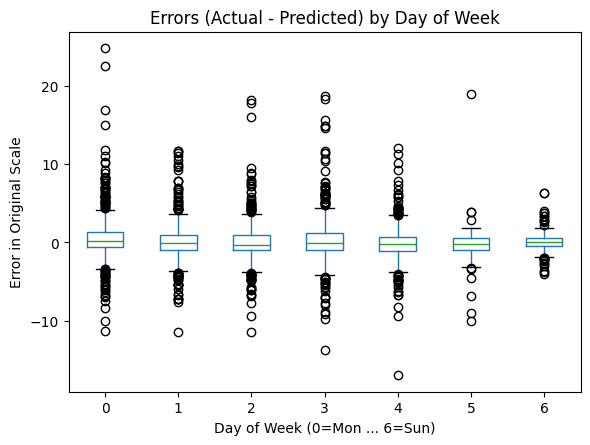

Model saved as './models/total_consumption_lstm_model.keras'


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# For saving the scaler
from joblib import dump

# ----------------------------------------------------------
# 1) Load data (already in a DataFrame 'df' with a DateTimeIndex).
#    For demonstration, let's assume columns are: ['Total_consumption'].
#    Sort by index to ensure chronological order, then split.
# ----------------------------------------------------------
df = df.sort_index()

total_samples = len(df)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.1)  # 70% train, 10% val, 20% test
test_size = total_samples - train_size - val_size

train_df = df.iloc[:train_size].copy()
val_df   = df.iloc[train_size:train_size+val_size].copy()
test_df  = df.iloc[train_size+val_size:].copy()

# ----------------------------------------------------------
# 2) Feature Engineering
#    We'll create time-based columns in each set separately
#    so we don't leak future info.
# ----------------------------------------------------------
# Example: hour, day_of_week. 
train_df['hour'] = train_df.index.hour
train_df['day_of_week'] = train_df.index.dayofweek

val_df['hour'] = val_df.index.hour
val_df['day_of_week'] = val_df.index.dayofweek

test_df['hour'] = test_df.index.hour
test_df['day_of_week'] = test_df.index.dayofweek

# Example lags/rolling. Adjust if day-ahead vs next hour:
train_df['lag1'] = train_df['Total_consumption'].shift(1)
train_df['rolling24'] = train_df['Total_consumption'].shift(1).rolling(window=24, min_periods=1).mean()

val_df['lag1'] = val_df['Total_consumption'].shift(1)
val_df['rolling24'] = val_df['Total_consumption'].shift(1).rolling(window=24, min_periods=1).mean()

test_df['lag1'] = test_df['Total_consumption'].shift(1)
test_df['rolling24'] = test_df['Total_consumption'].shift(1).rolling(window=24, min_periods=1).mean()

# Drop NA (start of each set might have NaN from shifting)
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# ----------------------------------------------------------
# 3) Scaling
#    Fit on train only, transform val/test.
# ----------------------------------------------------------
scaler = MinMaxScaler()
features_to_scale = ['Total_consumption','lag1','rolling24']

# Fit on training data
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
# Save the fitted scaler for future reuse
dump(scaler, './models/total_consumption_scaler.joblib')
print("Scaler fitted and saved to './models/total_consumption_scaler.joblib'")

# Now transform validation and test sets (using the same scaler)
val_df[features_to_scale]   = scaler.transform(val_df[features_to_scale])
test_df[features_to_scale]  = scaler.transform(test_df[features_to_scale])

# ----------------------------------------------------------
# 4) Create sequences for LSTM
#    We'll store day_of_week for the target hour to group error analysis later.
# ----------------------------------------------------------
sequence_length = 24
feature_cols = ['Total_consumption','hour','day_of_week','lag1','rolling24']
target_col = 'Total_consumption'

def make_sequences(df, feature_cols, target_col, seq_len):
    X, y = [], []
    day_of_week_target = []
    
    values = df[feature_cols].values
    targets = df[target_col].values
    dow_values = df['day_of_week'].values  # for boxplot grouping
    
    for i in range(seq_len, len(df)):
        X.append(values[i-seq_len:i])
        y.append(targets[i])
        # The day_of_week for the target time step i:
        day_of_week_target.append(dow_values[i])
        
    return np.array(X), np.array(y), np.array(day_of_week_target)

X_train, y_train, dow_train = make_sequences(train_df, feature_cols, target_col, sequence_length)
X_val,   y_val,   dow_val   = make_sequences(val_df,   feature_cols, target_col, sequence_length)
X_test,  y_test,  dow_test  = make_sequences(test_df,  feature_cols, target_col, sequence_length)

print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:  ", X_val.shape,   y_val.shape)
print("Test shapes: ", X_test.shape,  y_test.shape)

# ----------------------------------------------------------
# 5) Build LSTM
# ----------------------------------------------------------
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# ----------------------------------------------------------
# 6) Evaluation on Test Set
#    We'll compute R² in scaled space or we can invert.
#    Then plot predictions vs actual.
# ----------------------------------------------------------
y_pred_test = model.predict(X_test)

# MSE on test
mse_test = np.mean((y_test - y_pred_test)**2)
rmse_test = np.sqrt(mse_test)
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# R^2 in scaled domain
r2 = r2_score(y_test, y_pred_test)
print(f"Test R2 score: {r2:.4f}")

# Visualization: Test Predictions vs. Actual (scaled)
plt.figure(figsize=(14,5))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred_test, label='Predicted', linewidth=2)
plt.title("Test Set: Predicted vs Actual (Scaled)")
plt.legend()
plt.show()

# ----------------------------------------------------------
# Optional: Inverse transform
# If we want the actual errors in original scale, we can do an inverse transform 
# for the target. We must feed back a shape that matches the scaled columns.
# ----------------------------------------------------------
y_test_reshaped = y_test.reshape(-1,1)
y_pred_reshaped = y_pred_test.reshape(-1,1)

# We'll build placeholders for [lag1, rolling24] just to do the inverse transform
# though it's not always strictly necessary. We'll fill them with zeros.
dummy_col_count = len(features_to_scale) - 1  # =2 if we have 3 features to scale
dummy_zeros = np.zeros_like(y_test_reshaped).repeat(dummy_col_count, axis=1)

test_scaled_for_inverse = np.hstack([y_test_reshaped, dummy_zeros])
pred_scaled_for_inverse = np.hstack([y_pred_reshaped, dummy_zeros])

# We'll also need to reconstruct them into a DataFrame with the same columns order
# so that we can apply scaler.inverse_transform properly. 
inverse_df_cols = ['Total_consumption','lag1','rolling24']  # same order as features_to_scale
test_scaled_df = pd.DataFrame(test_scaled_for_inverse, columns=inverse_df_cols)
pred_scaled_df = pd.DataFrame(pred_scaled_for_inverse, columns=inverse_df_cols)

y_test_original = scaler.inverse_transform(test_scaled_df)[:,0]  # first col is 'Total_consumption'
y_pred_original = scaler.inverse_transform(pred_scaled_df)[:,0]

# Compute errors in original scale
errors = y_test_original - y_pred_original

# ----------------------------------------------------------
# 7) Boxplot of errors by day of week
# We'll use the day_of_week array for the test set (dow_test).
# For each sample in X_test/y_test, we also have dow_test[i].
# We group errors by day_of_week and produce a boxplot.
# ----------------------------------------------------------
df_errors = pd.DataFrame({
    'day_of_week': dow_test,
    'error': errors
})

# day_of_week is 0=Monday ... 6=Sunday
plt.figure(figsize=(10,6))
df_errors.boxplot(column='error', by='day_of_week', grid=False)
plt.title("Errors (Actual - Predicted) by Day of Week")
plt.suptitle("")  # Remove default title
plt.xlabel("Day of Week (0=Mon ... 6=Sun)")
plt.ylabel("Error in Original Scale")
plt.show()

# ----------------------------------------------------------
# 8) Save the Model
# ----------------------------------------------------------
model.save("./models/total_consumption_lstm_model.keras")
print("Model saved as './models/total_consumption_lstm_model.keras'")
